# Промышленность. Предсказание температуры сплава

**Описание проекта:** Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.  

**Цель исследования —** построить модель, которая будет предсказывать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Описание процесса обработки:** Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных:**
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:  
`steel.data_arc` — данные об электродах;  
`steel.data_bulk` — данные об объёме сыпучих материалов;  
`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;  
`steel.data_gas` — данные о продувке сплава газом;  
`steel.data_temp` — данные об измерениях температуры;  
`steel.data_wire` — данные об объёме проволочных материалов;  
`steel.data_wire_time` — данные о времени подачи проволочных материалов;  

# Содержание проекта:

 - [Шаг 1. Загрузка данных](#getting-data)
 - [Шаг 2. Исследовательский анализ и предобработка данных](#eda-and-preprocessing)
 - [Шаг 3. Обучение моделей](#model-learning)
 - [Шаг 4. Тестирование модели и демонстрация её работы](#model-testing)
 - [Шаг 5. Общий вывод](#conclusion)

Импортируем полезные библиотеки, объявим константы, зададим параметры по умолчанию и напишем полезные для проекта функции

In [1]:
!pip install phik optuna scikit-learn~=1.5.0
# data manipulation
import numpy as np
import pandas as pd

# database
import psycopg2

# plotting
import matplotlib.pyplot as plt

# math and optimization
import math
import phik
import optuna
from phik.report import plot_correlation_matrix

# utility
from IPython.core.display import display, HTML
from functools import partial

# time series
import datetime

# sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.pipeline import Pipeline

# lightgbm
from lightgbm import LGBMRegressor, plot_importance

# neural networks
import torch
import torch.nn as nn

# constant values
RANDOM_STATE = 110624
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

# set default values
display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
plt.rc('figure', figsize=(18, 12))                                 # controls figure size
set_config(display='diagram')

# Функция переводит строку с временем в секунды
def total_seconds(time_str):
    if time_str is None:
        return None
    
    formated = pd.to_datetime(time_str, format='%H:%M:%S')
    return datetime.timedelta(hours=formated.hour,
                              minutes=formated.minute,
                              seconds=formated.second).total_seconds()

<a name="getting-data"></a>
## Загрузка данных

### Подключимся к базе данных

In [2]:
db_config = {
'user': 'praktikum_student',
'password': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'database': 'data-science-final'
}

conn = psycopg2.connect(**db_config) 
cur = conn.cursor() 

<a name="eda-and-preprocessing"></a>
## Исследовательский анализ и предобработка данных

### Проверим соответствует ли количество таблиц условию задачи:

In [3]:
cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='steel'")
table_names = pd.Series(data=[data_tuple[0] for data_tuple in cur.fetchall()], name='table_names')
table_names

0          data_arc
1         data_bulk
2    data_bulk_time
3          data_gas
4         data_temp
5         data_wire
6    data_wire_time
Name: table_names, dtype: object

### Проверим все ли таблицы содержат данные:

In [4]:
table_not_empty = pd.Series(index=table_names.values, dtype='bool', name='table_not_empty')
for table_name in table_names.values:
    cur.execute(f"SELECT EXISTS(SELECT 1 FROM steel.{table_name})")
    table_not_empty[table_name] = cur.fetchall()[0][0]
    
table_not_empty

data_arc          True
data_bulk         True
data_bulk_time    True
data_gas          True
data_temp         True
data_wire         True
data_wire_time    True
Name: table_not_empty, dtype: bool

### Загрузим все таблицы:

In [5]:
tables = {}

for table_name in table_names:
    cur.execute(f"SELECT * FROM steel.{table_name}")
    tables[table_name] = pd.DataFrame(data=cur.fetchall(),
                                      columns=[desc[0] for desc in cur.description])

#### Исправим нарушения правил хорошего стиля в названиях столбцов:
* несколько слов в названии запишем в «змеином_регистре»
* все символы сделаем строчными
* устраним пробелы

In [6]:
tables['data_arc'].rename(inplace=True, columns={
    'BeginHeat': 'begin_heat',
    'EndHeat': 'end_heat',
    'ActivePower': 'active_power',
    'ReactivePower': 'reactive_power' 
})
tables['data_bulk'].rename(inplace=True, columns=dict([(f'Bulk {i}', f'bulk_{i}') for i in range(1, 16)]))
tables['data_bulk_time'].rename(inplace=True, columns=dict([(f'Bulk {i}', f'bulk_{i}') for i in range(1, 16)]))
tables['data_temp'].rename(inplace=True, columns={'MesaureTime': 'measure_time', 'Temperature': 'temperature'})
tables['data_wire'].rename(inplace=True, columns=dict([(f'Wire {i}', f'wire_{i}') for i in range(1, 10)]))
tables['data_wire_time'].rename(inplace=True, columns=dict([(f'Wire {i}', f'wire_{i}') for i in range(1, 16)]))

# check
for table_name in table_names:
    display(table_name, tables[table_name].columns)

'data_arc'

Index(['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power'], dtype='object')

'data_bulk'

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

'data_bulk_time'

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

'data_gas'

Index(['key', 'gas'], dtype='object')

'data_temp'

Index(['key', 'measure_time', 'temperature'], dtype='object')

'data_wire'

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

'data_wire_time'

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

#### Исправим несоответствия типов в столбцах:

In [7]:
tables['data_arc']['active_power'] = pd.to_numeric(tables['data_arc']['active_power'])
tables['data_arc']['reactive_power'] = pd.to_numeric(tables['data_arc']['reactive_power'])
tables['data_gas']['gas'] = pd.to_numeric(tables['data_gas']['gas'])
tables['data_temp']['temperature'] = pd.to_numeric(tables['data_temp']['temperature'])

for i in range(1, 16):
    tables['data_bulk'][f'bulk_{i}'] = pd.to_numeric(tables['data_bulk'][f'bulk_{i}'])

for i in range(1, 10):
    tables['data_wire'][f'wire_{i}'] = pd.to_numeric(tables['data_wire'][f'wire_{i}'])
    
# check
for table_name in table_names:
    display(table_name, tables[table_name].dtypes)

'data_arc'

key                 int64
begin_heat         object
end_heat           object
active_power      float64
reactive_power    float64
dtype: object

'data_bulk'

key          int64
bulk_1     float64
bulk_2     float64
bulk_3     float64
bulk_4     float64
bulk_5     float64
bulk_6     float64
bulk_7     float64
bulk_8     float64
bulk_9     float64
bulk_10    float64
bulk_11    float64
bulk_12    float64
bulk_13    float64
bulk_14    float64
bulk_15    float64
dtype: object

'data_bulk_time'

key         int64
bulk_1     object
bulk_2     object
bulk_3     object
bulk_4     object
bulk_5     object
bulk_6     object
bulk_7     object
bulk_8     object
bulk_9     object
bulk_10    object
bulk_11    object
bulk_12    object
bulk_13    object
bulk_14    object
bulk_15    object
dtype: object

'data_gas'

key      int64
gas    float64
dtype: object

'data_temp'

key               int64
measure_time     object
temperature     float64
dtype: object

'data_wire'

key         int64
wire_1    float64
wire_2    float64
wire_3    float64
wire_4    float64
wire_5    float64
wire_6    float64
wire_7    float64
wire_8    float64
wire_9    float64
dtype: object

'data_wire_time'

key        int64
wire_1    object
wire_2    object
wire_3    object
wire_4    object
wire_5    object
wire_6    object
wire_7    object
wire_8    object
wire_9    object
dtype: object

Напишем функцию для комплексного исследовательского анализа данных для того, чтобы не повторять код для каждой таблицы

In [8]:
def exploratory_data_analysis(table, bad_columns):
    # Ознакомимся с набором данных
    display(table.head())
    
    # Отобразим информацию для краткого обзора данных
    table.info()
    
    # Изучим пропущенные значения
    display(table.isna().sum())
    
    # Отобразим таблицу с описательной статистикой столбцов
    display(table.describe())
    
    # Отобразим диаграммы размаха и гистограммы распределений значений для столбцов
    for col in table.columns.difference(bad_columns):
        fig = plt.figure(figsize=(24, 12))
        ax = plt.subplot(2, 1, 1)
        table[col].plot(kind='box')
        
        ax = plt.subplot(2, 1, 2)
        ax.set_xlabel(col)
        table[col].plot(kind='hist', bins=25)
        plt.show()

### Изучим таблицу `steel.data_arc`:

#### Ознакомимся с набором данных:

,key,begin_heat,end_heat,active_power,reactive_power
0,1,11:02:14,11:06:02,0.9761,0.6871
1,1,11:07:28,11:10:33,0.8056,0.5203
2,1,11:11:44,11:14:36,0.7444,0.4988
3,1,11:18:14,11:24:19,1.6594,1.0627
4,1,11:26:09,11:28:37,0.6928,0.4144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   begin_heat      14876 non-null  object 
 2   end_heat        14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


key               0
begin_heat        0
end_heat          0
active_power      0
reactive_power    0
dtype: int64

,key,active_power,reactive_power
count,14876.0000,14876.0000,14876.0000
mean,1615.2204,0.6704,0.4526
std,934.5715,0.4082,5.8787
min,1.0000,0.0300,-715.5049
25%,806.0000,0.3953,0.2910
50%,1617.0000,0.5555,0.4160
75%,2429.0000,0.8570,0.6374
max,3241.0000,3.7316,2.6764


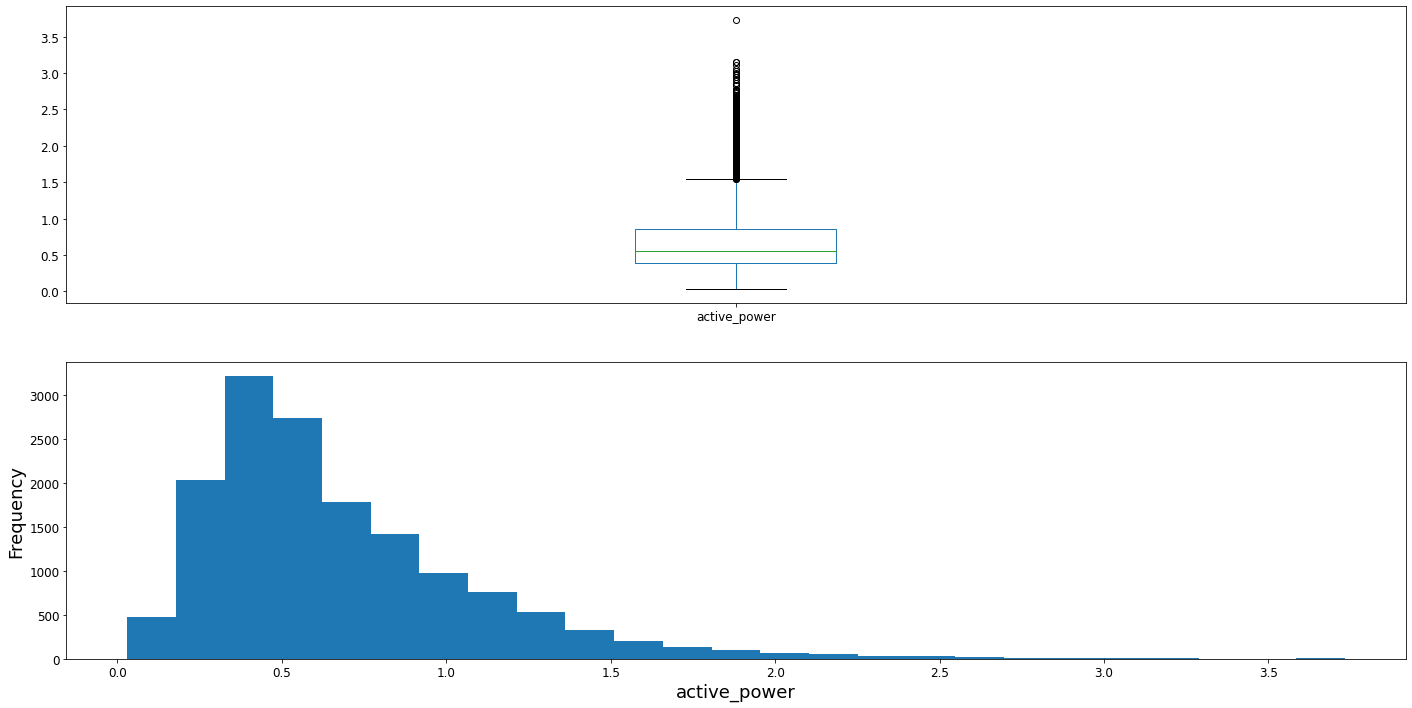

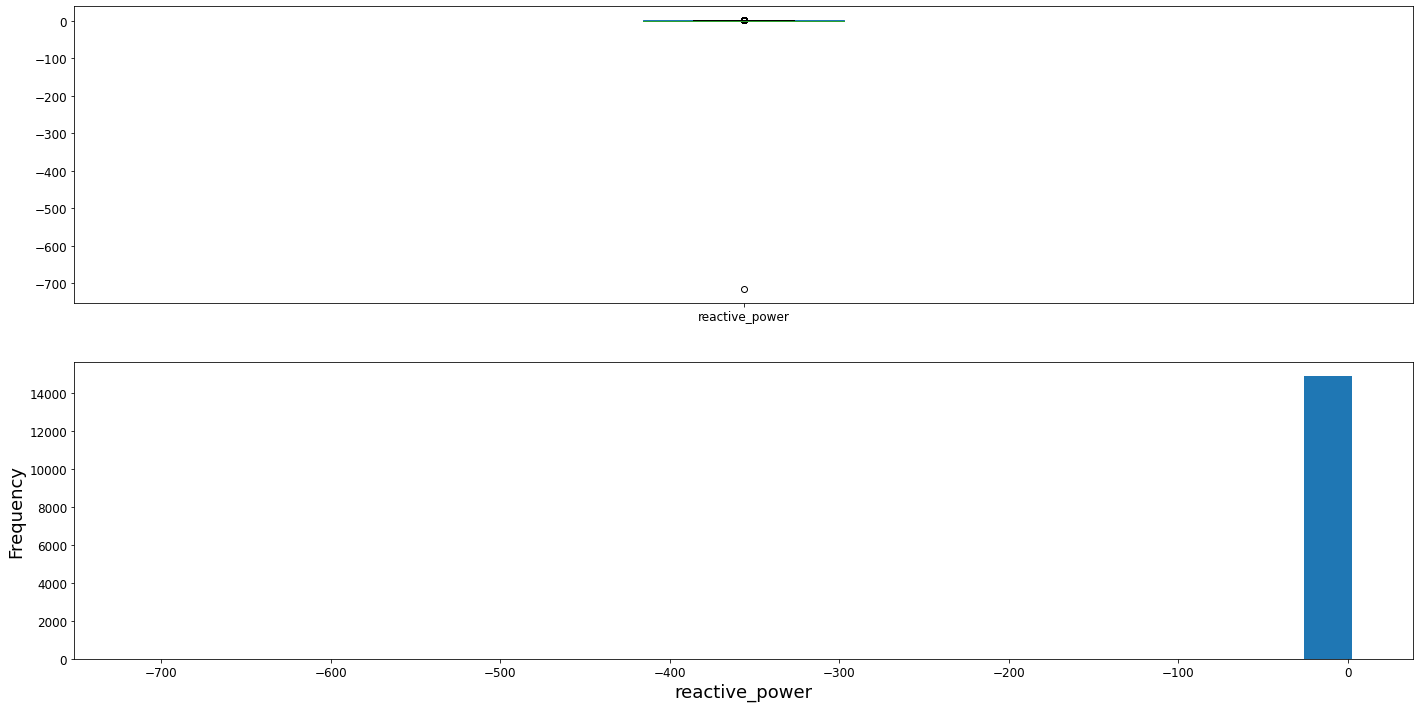

In [9]:
exploratory_data_analysis(tables['data_arc'], bad_columns=['key', 'begin_heat', 'end_heat'])

#### Обработаем аномальные значения:

Рассмотрим отрицательные значения мощности

In [10]:
active_min = 0.0
reactive_min = 0.0

active_anomalies = tables['data_arc']['active_power'] < active_min
reactive_anomalies = tables['data_arc']['reactive_power'] < reactive_min
anomaly_keys = tables['data_arc'][active_anomalies | reactive_anomalies].key.unique()

print(f"Number of anomaly batches: {anomaly_keys.shape[0]}")

Number of anomaly batches: 1


Число партий с аномальными значениями не слишком велико. Удалим все такие партии из таблицы

In [11]:
tables['data_arc'] = tables['data_arc'][~tables['data_arc']['key'].isin(anomaly_keys)]

#### Сгенерируем новые столбцы, которые могут пригодиться при обучении:

In [12]:
tables['data_arc']['heat_time'] = tables['data_arc']['end_heat'].apply(total_seconds) -\
                                  tables['data_arc']['begin_heat'].apply(total_seconds)
tables['data_arc']['absolute_power'] = tables['data_arc']['active_power'] +\
                                       tables['data_arc']['reactive_power']
tables['data_arc']['relative_power'] = tables['data_arc']['active_power'] /\
                                       tables['data_arc']['reactive_power']
tables['data_arc']['heat_count'] = 1

# check
tables['data_arc'].head()

,key,begin_heat,end_heat,active_power,reactive_power,heat_time,absolute_power,relative_power,heat_count
0,1,11:02:14,11:06:02,0.9761,0.6871,228.0000,1.6631,1.4206,1
1,1,11:07:28,11:10:33,0.8056,0.5203,185.0000,1.3259,1.5484,1
2,1,11:11:44,11:14:36,0.7444,0.4988,172.0000,1.2432,1.4923,1
3,1,11:18:14,11:24:19,1.6594,1.0627,365.0000,2.7220,1.5615,1
4,1,11:26:09,11:28:37,0.6928,0.4144,148.0000,1.1072,1.6717,1


#### Агрегируем наблюдения по номеру партии:

In [13]:
tables['data_arc'] = tables['data_arc'].groupby('key').agg({
    'active_power': 'mean',
    'reactive_power': 'mean',
    'heat_time': 'sum',
    'absolute_power': 'mean',
    'relative_power': 'mean',
    'heat_count': 'sum'
})

# check
tables['data_arc'].head()

,active_power,reactive_power,heat_time,absolute_power,relative_power,heat_count
key,,,,,,
1,0.9756,0.6366,1098.0000,1.6123,1.5389,5
2,0.7631,0.4995,811.0000,1.2627,1.5518,4
3,0.5052,0.3198,655.0000,0.8250,1.5831,5
4,0.8023,0.5151,741.0000,1.3174,1.5635,4
5,0.8368,0.5632,869.0000,1.4000,1.4804,4


### Изучим таблицу `steel.data_bulk`:

#### Ознакомимся с набором данных:

In [14]:
exploratory_data_analysis(tables['data_bulk'], bad_columns=['key'] + [f'bulk_{i}' for i in range(1, 16)])

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,150.0000,154.0000
1,2,NaN,NaN,NaN,73.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,149.0000,154.0000
2,3,NaN,NaN,NaN,34.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0000,NaN,152.0000,153.0000
3,4,NaN,NaN,NaN,81.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0000,NaN,153.0000,154.0000
4,5,NaN,NaN,NaN,78.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0000,NaN,151.0000,152.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.0000,252.0000,22.0000,1298.0000,1014.0000,77.0000,576.0000,25.0000,1.0000,19.0000,176.0000,177.0000,2450.0000,18.0000,2806.0000,2248.0000
mean,1624.3835,39.2421,253.0455,113.8790,104.3945,107.0260,118.9253,305.6000,49.0000,76.3158,83.2841,76.8192,260.4710,181.1111,170.2847,160.5133
std,933.3376,18.2777,21.1806,75.4835,48.1841,81.7906,72.0578,191.0229,NaN,21.7206,26.0603,59.6554,120.6493,46.0880,65.8687,51.7653
min,1.0000,10.0000,228.0000,6.0000,12.0000,11.0000,17.0000,47.0000,49.0000,63.0000,24.0000,8.0000,53.0000,151.0000,16.0000,1.0000
25%,816.0000,27.0000,242.0000,58.0000,72.0000,70.0000,69.7500,155.0000,49.0000,66.0000,64.0000,25.0000,204.0000,153.2500,119.0000,105.0000
50%,1622.0000,31.0000,251.5000,97.5000,102.0000,86.0000,100.0000,298.0000,49.0000,68.0000,86.5000,64.0000,208.0000,155.5000,151.0000,160.0000
75%,2431.0000,46.0000,257.7500,152.0000,133.0000,132.0000,157.0000,406.0000,49.0000,70.5000,102.0000,106.0000,316.0000,203.5000,205.7500,205.0000
max,3241.0000,185.0000,325.0000,454.0000,281.0000,603.0000,503.0000,772.0000,49.0000,147.0000,159.0000,313.0000,1849.0000,305.0000,636.0000,405.0000


В данной таблице пропуски означают нулевой объём подаваемого материала. Заполним их соответствующим значением

In [15]:
tables['data_bulk'] = tables['data_bulk'].fillna(0)

# check
tables['data_bulk'].head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0000,0.0000,0.0000,43.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,150.0000,154.0000
1,2,0.0000,0.0000,0.0000,73.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,149.0000,154.0000
2,3,0.0000,0.0000,0.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,205.0000,0.0000,152.0000,153.0000
3,4,0.0000,0.0000,0.0000,81.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,207.0000,0.0000,153.0000,154.0000
4,5,0.0000,0.0000,0.0000,78.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,203.0000,0.0000,151.0000,152.0000


### Изучим таблицу steel.data_bulk_time:

#### Ознакомимся с набором данных:

In [16]:
exploratory_data_analysis(tables['data_bulk_time'], bad_columns=['key'] + [f'bulk_{i}' for i in range(1, 16)])

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

,key
count,3129.0000
mean,1624.3835
std,933.3376
min,1.0000
25%,816.0000
50%,1622.0000
75%,2431.0000
max,3241.0000


#### Убедимся, что подача материала не измеряется сутками:

In [17]:
display(tables['data_bulk_time'].drop(columns=['key']).apply(lambda row: pd.to_datetime(row, format='%H:%M:%S')).min())
display(tables['data_bulk_time'].drop(columns=['key']).apply(lambda row: pd.to_datetime(row, format='%H:%M:%S')).max())

bulk_1    1900-01-01 00:00:13
bulk_2    1900-01-01 08:36:19
bulk_3    1900-01-01 00:00:01
bulk_4    1900-01-01 00:00:38
bulk_5    1900-01-01 00:01:33
bulk_6    1900-01-01 00:01:25
bulk_7    1900-01-01 00:42:38
bulk_8    1900-01-01 17:46:11
bulk_9    1900-01-01 00:04:56
bulk_10   1900-01-01 00:01:01
bulk_11   1900-01-01 00:28:29
bulk_12   1900-01-01 00:01:00
bulk_13   1900-01-01 00:39:35
bulk_14   1900-01-01 00:00:11
bulk_15   1900-01-01 00:01:00
dtype: datetime64[ns]

bulk_1    1900-01-01 23:54:24
bulk_2    1900-01-01 18:01:50
bulk_3    1900-01-01 23:57:32
bulk_4    1900-01-01 23:59:30
bulk_5    1900-01-01 23:42:34
bulk_6    1900-01-01 23:56:15
bulk_7    1900-01-01 18:01:50
bulk_8    1900-01-01 17:46:11
bulk_9    1900-01-01 18:58:01
bulk_10   1900-01-01 23:32:50
bulk_11   1900-01-01 23:56:15
bulk_12   1900-01-01 23:58:54
bulk_13   1900-01-01 23:34:05
bulk_14   1900-01-01 23:58:54
bulk_15   1900-01-01 23:58:54
dtype: datetime64[ns]

Можно заметить, что материал подаётся в течении одних суток. Поэтому мы можем закодировать время подачи материала числом из отрезка $[0, 86399]$, равное количеству секунд, которое прошло с начала дня

In [18]:
tables['data_bulk_time'].loc[:, 'bulk_1':'bulk_15'] = tables['data_bulk_time'].drop(columns=['key']).applymap(total_seconds)

#### Обработаем пропущенные значения:

Заполним пропуски значением по умолчанию: $-1.0$

In [19]:
tables['data_bulk_time'] = tables['data_bulk_time'].fillna(-1.0)

# check
tables['data_bulk_time'].head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,-1.0000,-1.0000,-1.0000,40890.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,39832.0000,-1.0000,39832.0000,39832.0000
1,2,-1.0000,-1.0000,-1.0000,42398.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,42020.0000,-1.0000,42020.0000,42020.0000
2,3,-1.0000,-1.0000,-1.0000,45066.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,43780.0000,-1.0000,43780.0000,43780.0000
3,4,-1.0000,-1.0000,-1.0000,46123.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,45684.0000,-1.0000,45684.0000,45684.0000
4,5,-1.0000,-1.0000,-1.0000,47930.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,47576.0000,-1.0000,47576.0000,47576.0000


### Изучим таблицу steel.data_gas:

#### Ознакомимся с набором данных:

,key,gas
0,1,29.7500
1,2,12.5556
2,3,28.5548
3,4,18.8412
4,5,5.4137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key    0
gas    0
dtype: int64

,key,gas
count,3239.0000,3239.0000
mean,1621.8614,11.0021
std,935.3863,6.2203
min,1.0000,0.0084
25%,812.5000,7.0431
50%,1622.0000,9.8363
75%,2431.5000,13.7699
max,3241.0000,77.9950


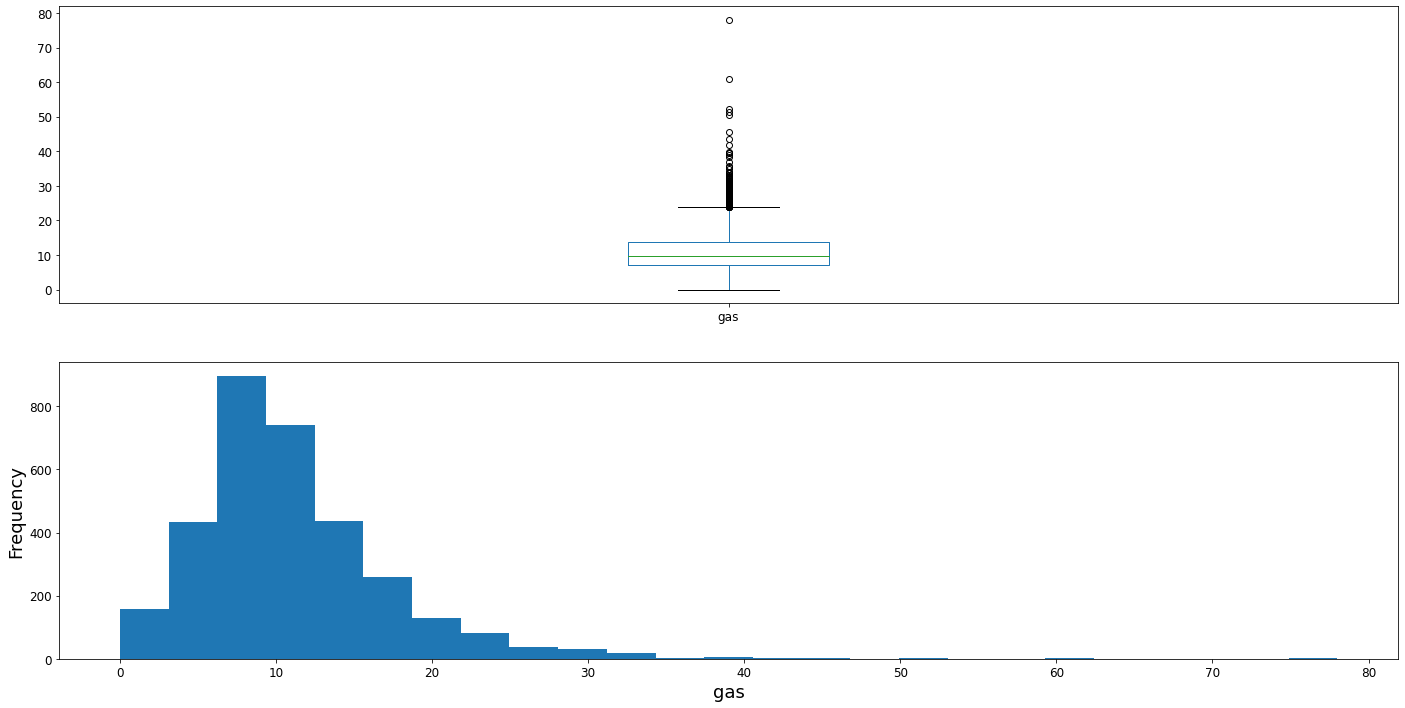

In [20]:
exploratory_data_analysis(tables['data_gas'], bad_columns=['key'])

### Изучим таблицу `steel.data_temp`:

#### Ознакомимся с набором данных:

,key,measure_time,temperature
0,1,11:16:18,1571.0000
1,1,11:25:53,1604.0000
2,1,11:29:11,1618.0000
3,1,11:30:01,1601.0000
4,1,11:30:39,1613.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   measure_time  15907 non-null  object 
 2   temperature   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


key                0
measure_time       0
temperature     2901
dtype: int64

,key,temperature
count,15907.0000,13006.0000
mean,1607.8809,1591.8409
std,942.2121,21.3759
min,1.0000,1191.0000
25%,790.0000,1581.0000
50%,1618.0000,1591.0000
75%,2427.0000,1601.0000
max,3241.0000,1705.0000


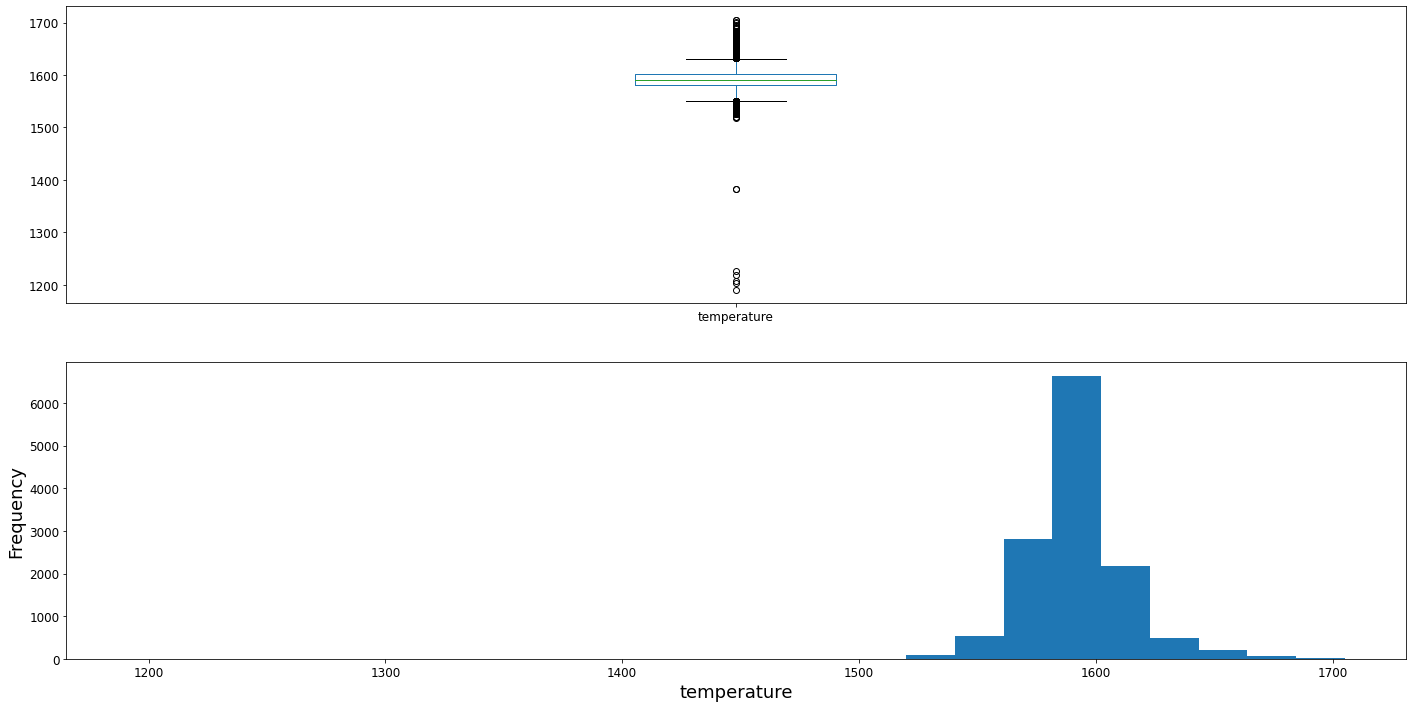

In [21]:
exploratory_data_analysis(tables['data_temp'], bad_columns=['key', 'measure_time'])

#### Удалим все строки с пропущенными значениями температуры

In [22]:
tables['data_temp'] = tables['data_temp'][~tables['data_temp']['temperature'].isna()]

#### Удалим все строки с аномальными значениями температуры

In [23]:
tables['data_temp'] = tables['data_temp'][tables['data_temp']['temperature'] >= 1500]

#### Агрегируем наблюдения по номеру партии:

Оставим только те партии, у которых есть как минимум два наблюдения

In [24]:
tables['data_temp'] = tables['data_temp'][tables['data_temp'].key.duplicated(keep=False)]

Оставим только начальную и последнюю температуры партии

In [25]:
first_measurement = tables['data_temp'][~tables['data_temp'].key.duplicated(keep='first')]
first_measurement = first_measurement.drop(columns=['measure_time'])

last_measurement = tables['data_temp'][~tables['data_temp'].key.duplicated(keep='last')]
last_measurement = last_measurement.drop(columns=['measure_time'])

tables['data_temp'] = pd.merge(left=first_measurement,
                               right=last_measurement,
                               on='key',
                               suffixes=('_first', '_last'))

### Изучим таблицу `steel.data_wire`:

#### Ознакомимся с набором данных:

In [26]:
exploratory_data_analysis(tables['data_wire'], bad_columns=['key']+[f'wire_{i}' for i in range(1, 10)])

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.0523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.0635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.2382,9.1146,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.0000,3055.0000,1079.0000,63.0000,14.0000,1.0000,73.0000,11.0000,19.0000,29.0000
mean,1623.4265,100.8959,50.5773,189.4827,57.4428,15.1320,48.0170,10.0390,53.6252,34.1558
std,932.9967,42.0125,39.3202,99.5134,28.8247,NaN,33.9198,8.6106,16.8817,19.9316
min,1.0000,1.9188,0.0302,0.1441,24.1488,15.1320,0.0343,0.2342,45.0767,4.6228
25%,823.0000,72.1157,20.1937,95.1350,40.8070,15.1320,25.0536,6.7628,46.0949,22.0584
50%,1619.0000,100.1582,40.1430,235.1950,45.2343,15.1320,42.0763,9.0170,46.2800,30.0664
75%,2434.0000,126.0605,70.2276,276.2520,76.1246,15.1320,64.2127,11.8861,48.0896,43.8620
max,3241.0000,330.3144,282.7802,385.0087,113.2310,15.1320,180.4546,32.8477,102.7624,90.0536


В данной таблице пропуски означают нулевой объём подаваемого материала. Заполним их соответствующим значением

In [27]:
tables['data_wire'] = tables['data_wire'].fillna(0)

# check
tables['data_wire'].head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2,96.0523,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,3,91.1602,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,4,89.0635,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,5,89.2382,9.1146,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Изучим таблицу `steel.data_wire_time`:

#### Ознакомимся с набором данных:

In [28]:
exploratory_data_analysis(tables['data_wire_time'], bad_columns=['key']+[f'wire_{i}' for i in range(1, 10)])

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

,key
count,3081.0000
mean,1623.4265
std,932.9967
min,1.0000
25%,823.0000
50%,1619.0000
75%,2434.0000
max,3241.0000


#### Убедимся, что подача материала не измеряется сутками:

In [29]:
display(tables['data_wire_time'].drop(columns=['key']).apply(lambda row: pd.to_datetime(row, format='%H:%M:%S')).min())
display(tables['data_wire_time'].drop(columns=['key']).apply(lambda row: pd.to_datetime(row, format='%H:%M:%S')).max())

wire_1   1900-01-01 00:00:37
wire_2   1900-01-01 00:01:56
wire_3   1900-01-01 01:29:02
wire_4   1900-01-01 07:15:28
wire_5   1900-01-01 16:01:07
wire_6   1900-01-01 00:04:33
wire_7   1900-01-01 10:01:56
wire_8   1900-01-01 00:03:32
wire_9   1900-01-01 00:21:11
dtype: datetime64[ns]

wire_1   1900-01-01 23:59:55
wire_2   1900-01-01 23:58:54
wire_3   1900-01-01 23:27:46
wire_4   1900-01-01 18:09:32
wire_5   1900-01-01 16:01:07
wire_6   1900-01-01 23:47:40
wire_7   1900-01-01 19:46:16
wire_8   1900-01-01 18:58:07
wire_9   1900-01-01 23:59:16
dtype: datetime64[ns]

Можно заметить, что материал подаётся в течении одних суток. Поэтому мы можем закодировать время подачи материала числом из отрезка $[0, 86399]$, равное количеству секунд, которое прошло с начала дня

In [30]:
tables['data_wire_time'].loc[:, 'wire_1':'wire_9'] = tables['data_wire_time'].drop(columns=['key']).applymap(total_seconds)

#### Обработаем пропущенные значения:

Заполним пропуски значением по умолчанию: $-1.0$

In [31]:
tables['data_wire_time'] = tables['data_wire_time'].fillna(-1.0)

# check
tables['data_wire_time'].head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,40301.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
1,2,42370.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
2,3,44027.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
3,4,46085.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
4,5,47895.0000,48726.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000


### Краткий вывод:
В данных были устранены следующие проблемы:
- нарушения правил хорошего стиля в названиях столбцов
- несоответствия типов в столбцах
- пропуски в столбцах
- аномальные значения в столбцах

### Объединим таблицы по ключу:

In [32]:
data = tables['data_arc']
data = pd.merge(data, tables['data_bulk'], on='key')
data = pd.merge(data, tables['data_bulk_time'], on='key', suffixes=('', '_time'))
data = pd.merge(data, tables['data_gas'], on='key')
data = pd.merge(data, tables['data_temp'], on='key')
data = pd.merge(data, tables['data_wire'], on='key')
data = pd.merge(data, tables['data_wire_time'], on='key', suffixes=('', '_time'))

data.head()

,key,active_power,reactive_power,heat_time,absolute_power,relative_power,heat_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time,gas,temperature_first,temperature_last,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
0,1,0.9756,0.6366,1098.0000,1.6123,1.5389,5,0.0000,0.0000,0.0000,43.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,150.0000,154.0000,-1.0000,-1.0000,-1.0000,40890.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,39832.0000,-1.0000,39832.0000,39832.0000,29.7500,1571.0000,1613.0000,60.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,40301.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
1,2,0.7631,0.4995,811.0000,1.2627,1.5518,4,0.0000,0.0000,0.0000,73.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,149.0000,154.0000,-1.0000,-1.0000,-1.0000,42398.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,42020.0000,-1.0000,42020.0000,42020.0000,12.5556,1581.0000,1602.0000,96.0523,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,42370.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
2,3,0.5052,0.3198,655.0000,0.8250,1.5831,5,0.0000,0.0000,0.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,205.0000,0.0000,152.0000,153.0000,-1.0000,-1.0000,-1.0000,45066.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,43780.0000,-1.0000,43780.0000,43780.0000,28.5548,1596.0000,1599.0000,91.1602,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,44027.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
3,4,0.8023,0.5151,741.0000,1.3174,1.5635,4,0.0000,0.0000,0.0000,81.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,207.0000,0.0000,153.0000,154.0000,-1.0000,-1.0000,-1.0000,46123.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,45684.0000,-1.0000,45684.0000,45684.0000,18.8412,1601.0000,1625.0000,89.0635,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,46085.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
4,5,0.8368,0.5632,869.0000,1.4000,1.4804,4,0.0000,0.0000,0.0000,78.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,203.0000,0.0000,151.0000,152.0000,-1.0000,-1.0000,-1.0000,47930.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,47576.0000,-1.0000,47576.0000,47576.0000,5.4137,1576.0000,1602.0000,89.2382,9.1146,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,47895.0000,48726.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000


Для обучения будем использовать только столбцы `active_power`, `reactive_power`, `heat_time`, `absolute_power`, `relative_power`, `heat_count`, `gas`, `temperature_first`, `temperature_last`

In [33]:
columns = ['active_power', 'reactive_power', 'heat_time', 
           'absolute_power', 'relative_power', 'heat_count',
           'gas', 'temperature_first', 'temperature_last']

data = data[columns]

#### Ознакомимся с набором данных:

,active_power,reactive_power,heat_time,absolute_power,relative_power,heat_count,gas,temperature_first,temperature_last
0,0.9756,0.6366,1098.0000,1.6123,1.5389,5,29.7500,1571.0000,1613.0000
1,0.7631,0.4995,811.0000,1.2627,1.5518,4,12.5556,1581.0000,1602.0000
2,0.5052,0.3198,655.0000,0.8250,1.5831,5,28.5548,1596.0000,1599.0000
3,0.8023,0.5151,741.0000,1.3174,1.5635,4,18.8412,1601.0000,1625.0000
4,0.8368,0.5632,869.0000,1.4000,1.4804,4,5.4137,1576.0000,1602.0000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2328 non-null   float64
 1   reactive_power     2328 non-null   float64
 2   heat_time          2328 non-null   float64
 3   absolute_power     2328 non-null   float64
 4   relative_power     2328 non-null   float64
 5   heat_count         2328 non-null   int64  
 6   gas                2328 non-null   float64
 7   temperature_first  2328 non-null   float64
 8   temperature_last   2328 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 181.9 KB


active_power         0
reactive_power       0
heat_time            0
absolute_power       0
relative_power       0
heat_count           0
gas                  0
temperature_first    0
temperature_last     0
dtype: int64

,active_power,reactive_power,heat_time,absolute_power,relative_power,heat_count,gas,temperature_first,temperature_last
count,2328.0000,2328.0000,2328.0000,2328.0000,2328.0000,2328.0000,2328.0000,2328.0000,2328.0000
mean,0.6691,0.4994,176.8806,1.1685,1.3613,4.6959,11.3755,1587.3896,1593.3720
std,0.1969,0.1474,7353.8061,0.3377,0.1315,1.6069,6.3934,23.6243,11.1988
min,0.1862,0.1301,-86029.0000,0.3179,0.6877,1.0000,0.0084,1519.0000,1541.0000
25%,0.5265,0.3926,575.0000,0.9215,1.2940,4.0000,7.2825,1571.0000,1587.0000
50%,0.6445,0.4878,776.0000,1.1379,1.3734,5.0000,10.1007,1587.0000,1593.0000
75%,0.7921,0.5924,991.0000,1.3817,1.4414,6.0000,14.2169,1603.0000,1598.0000
max,1.4214,1.1350,4189.0000,2.5254,1.7822,16.0000,77.9950,1660.0000,1653.0000


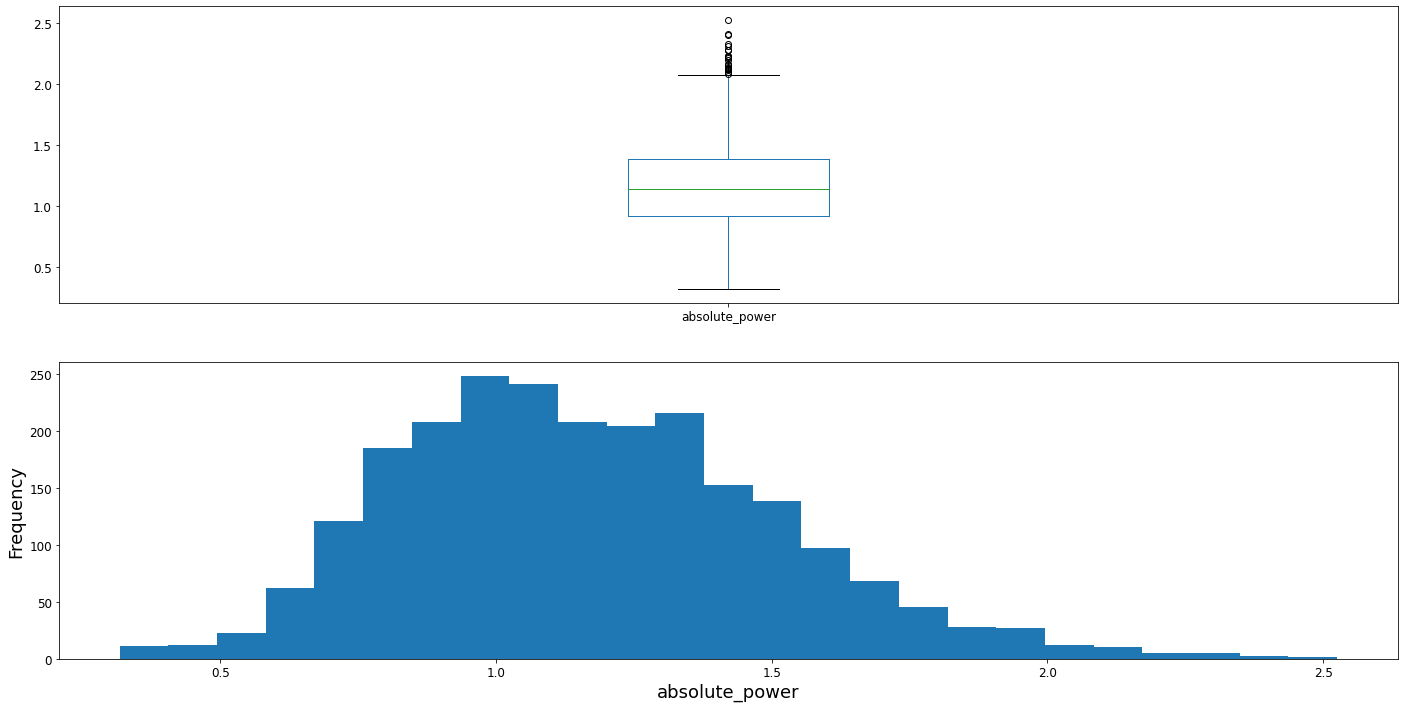

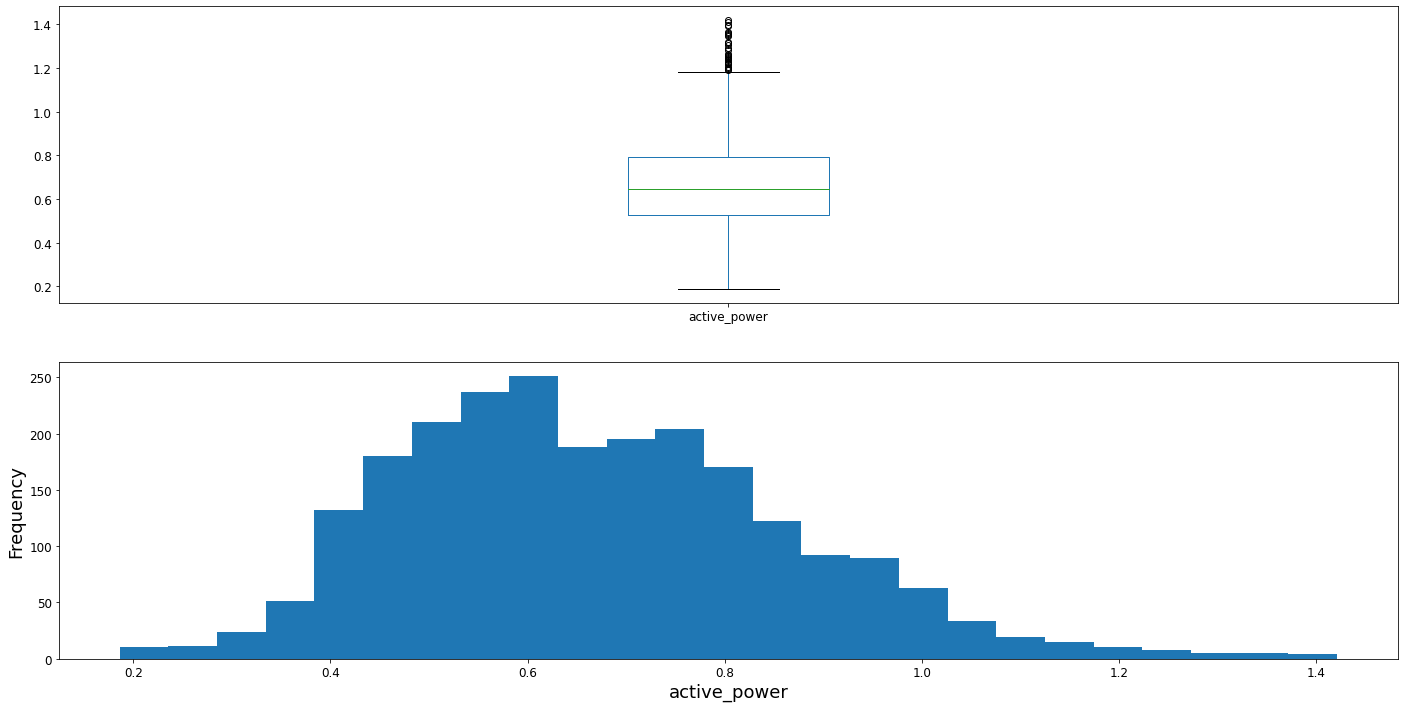

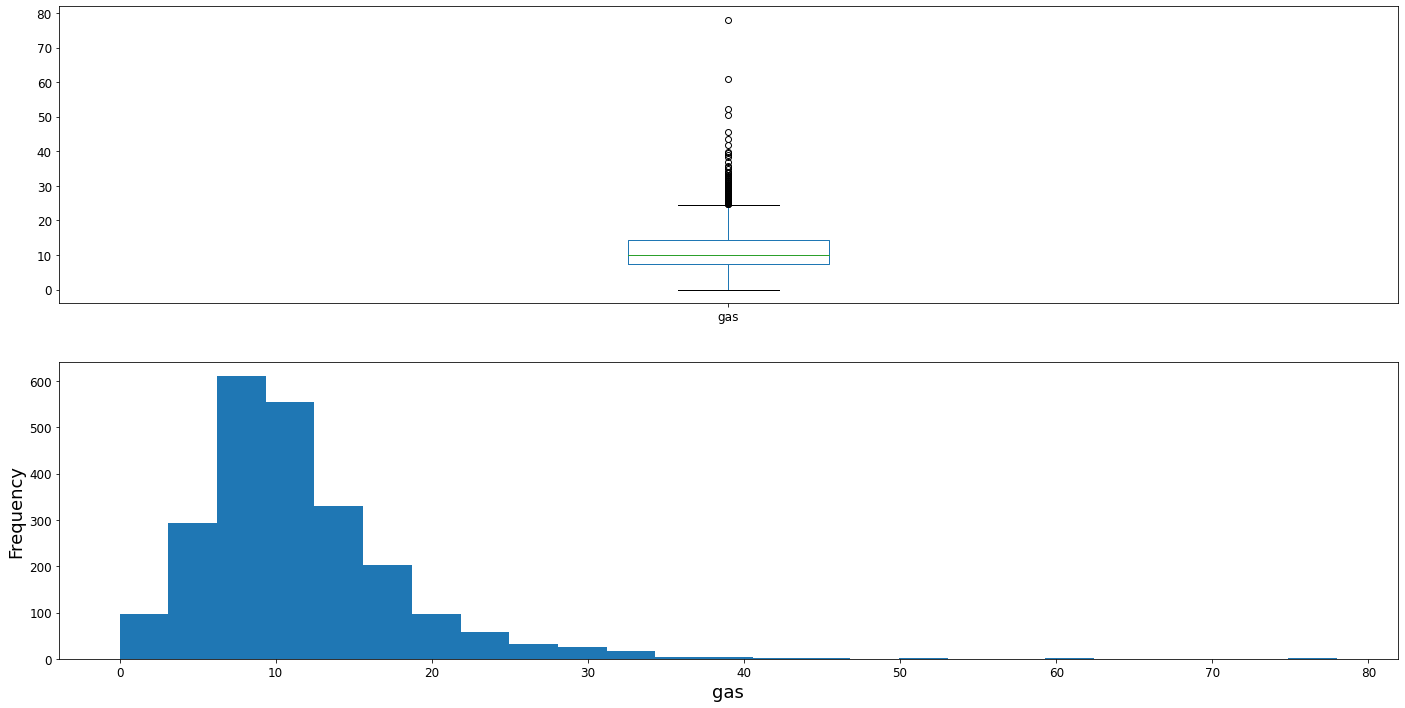

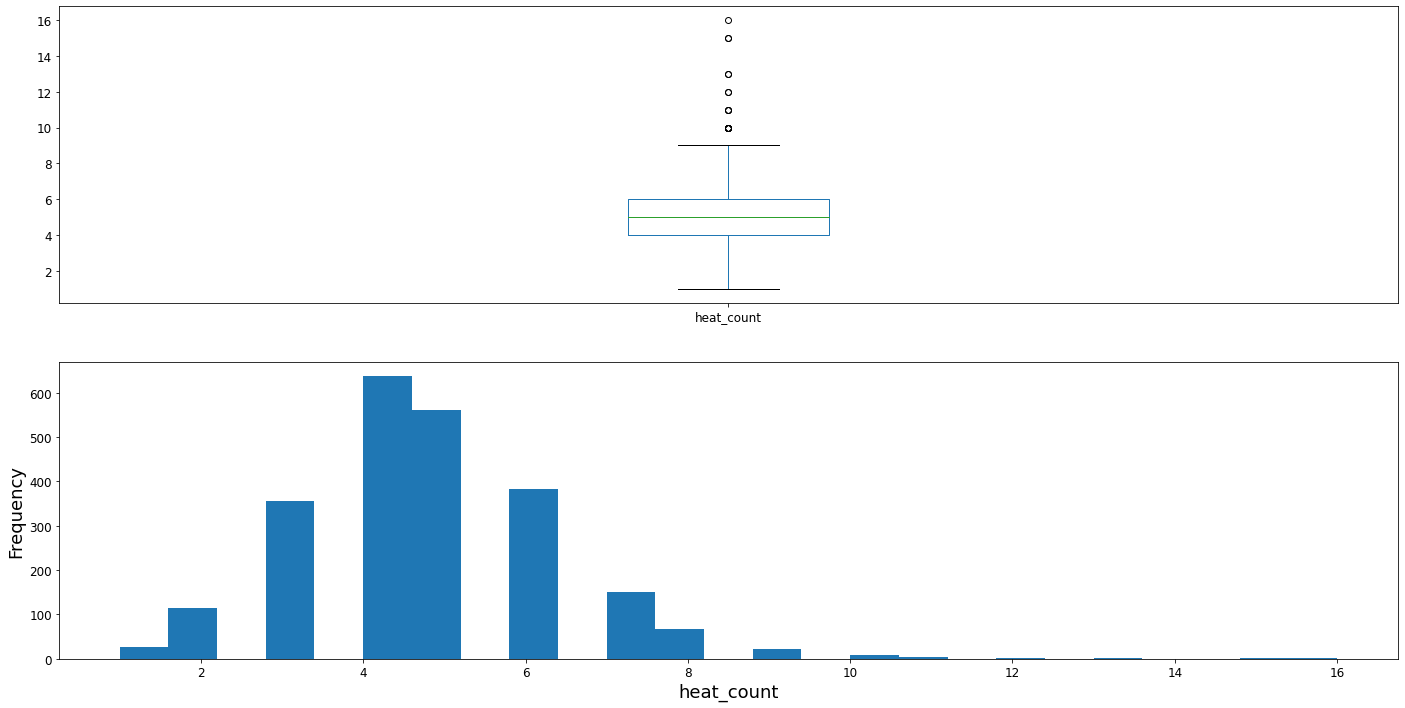

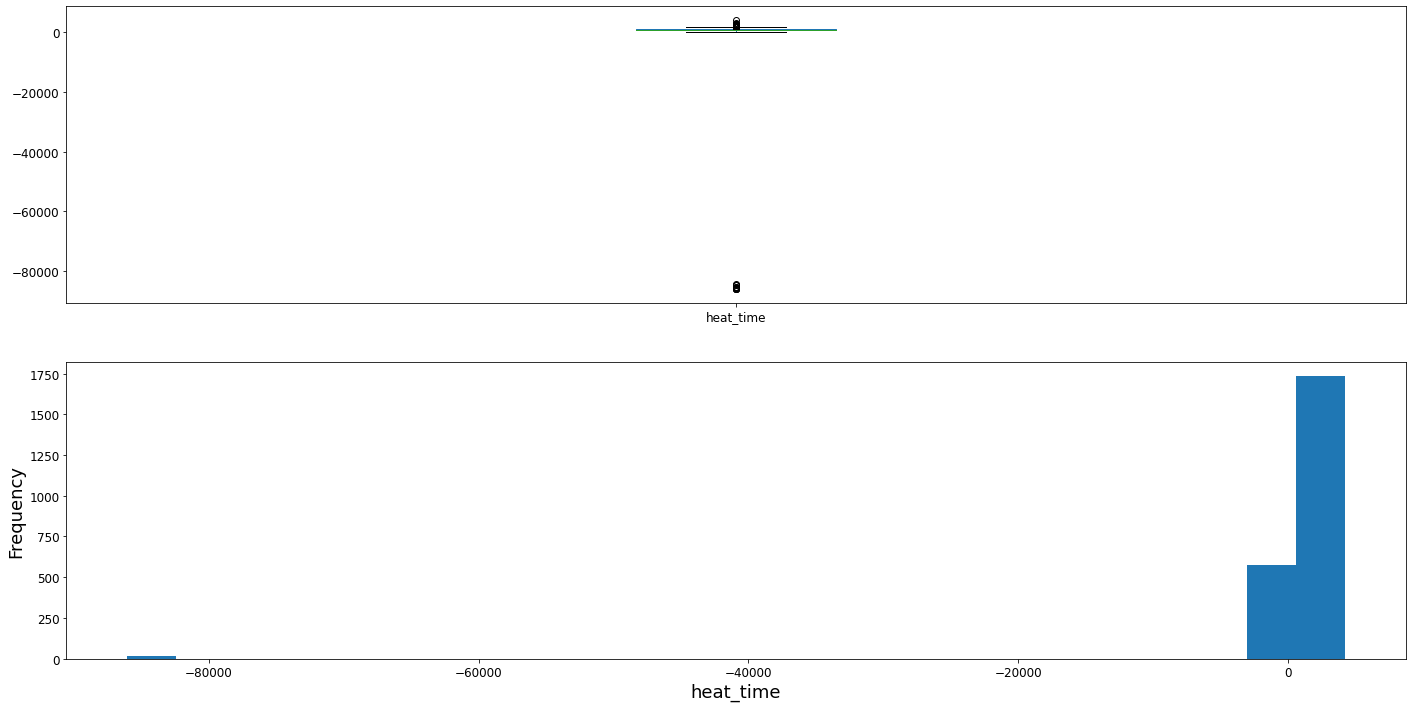

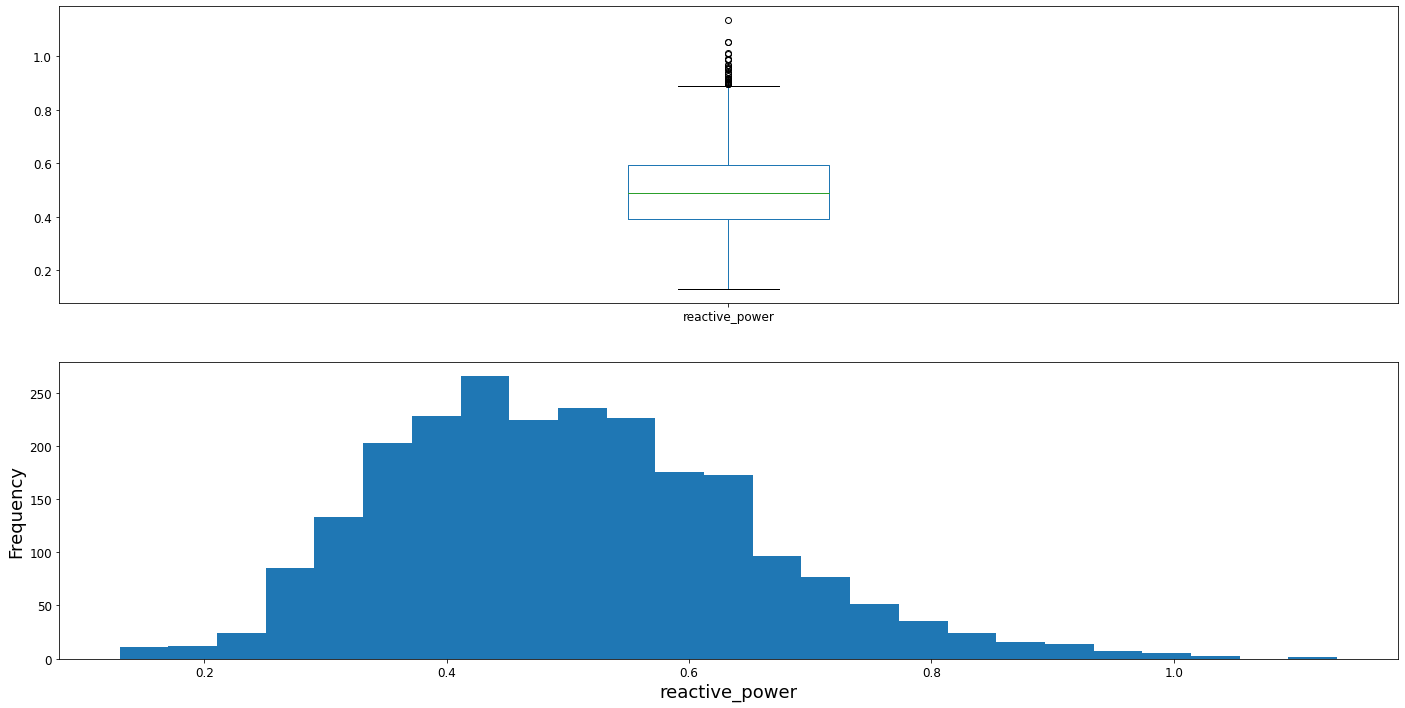

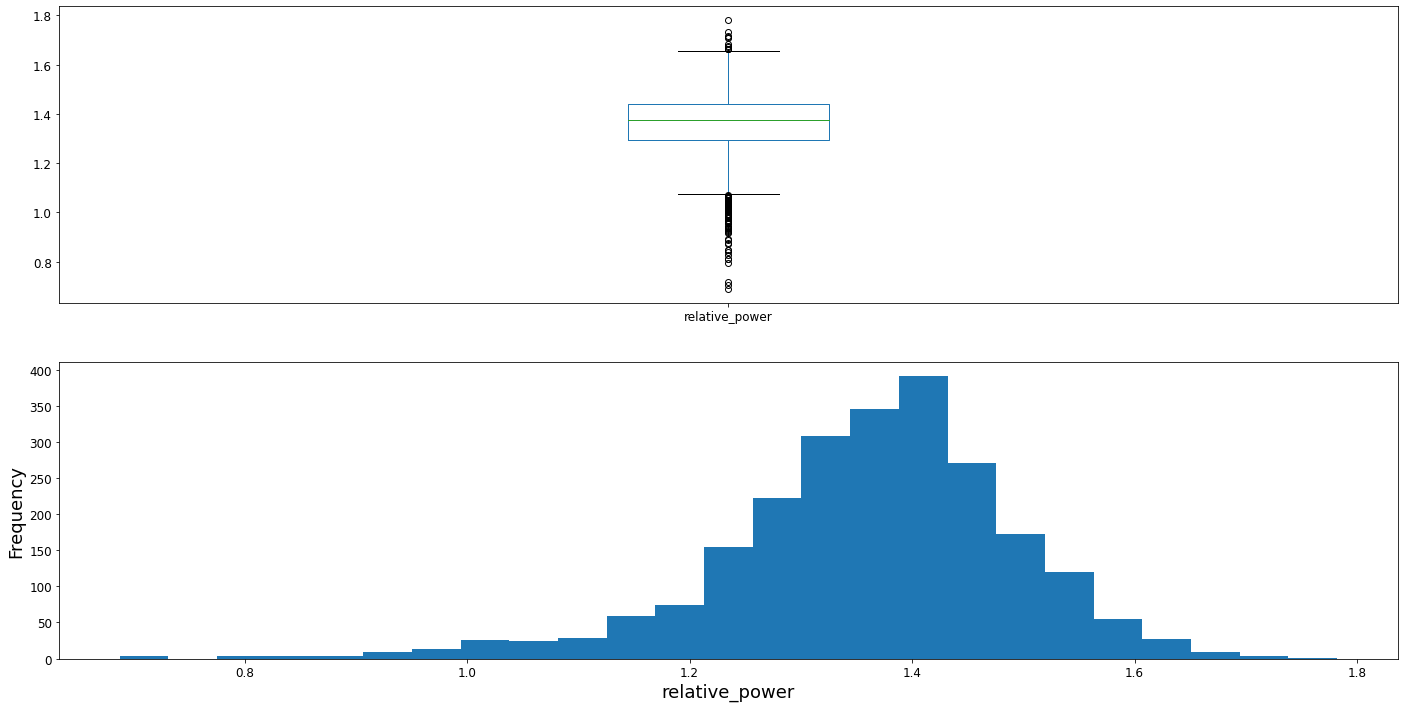

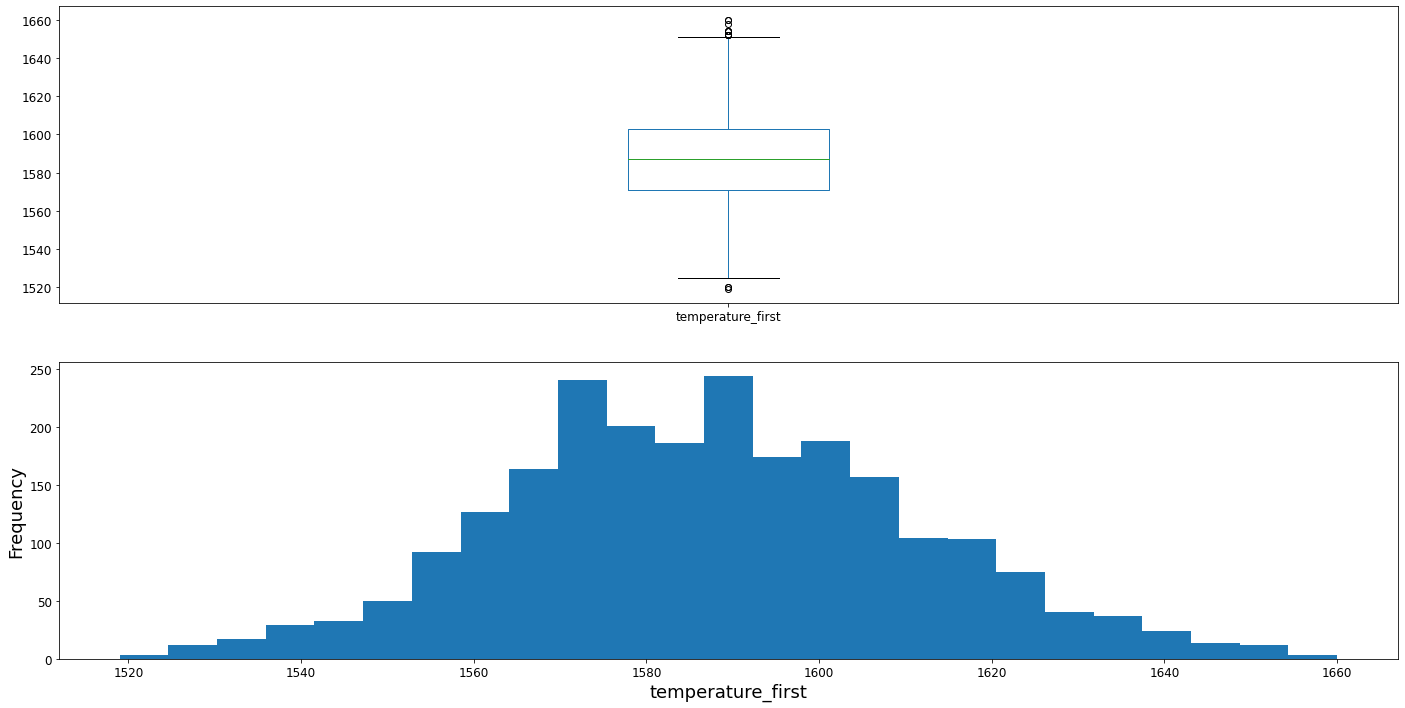

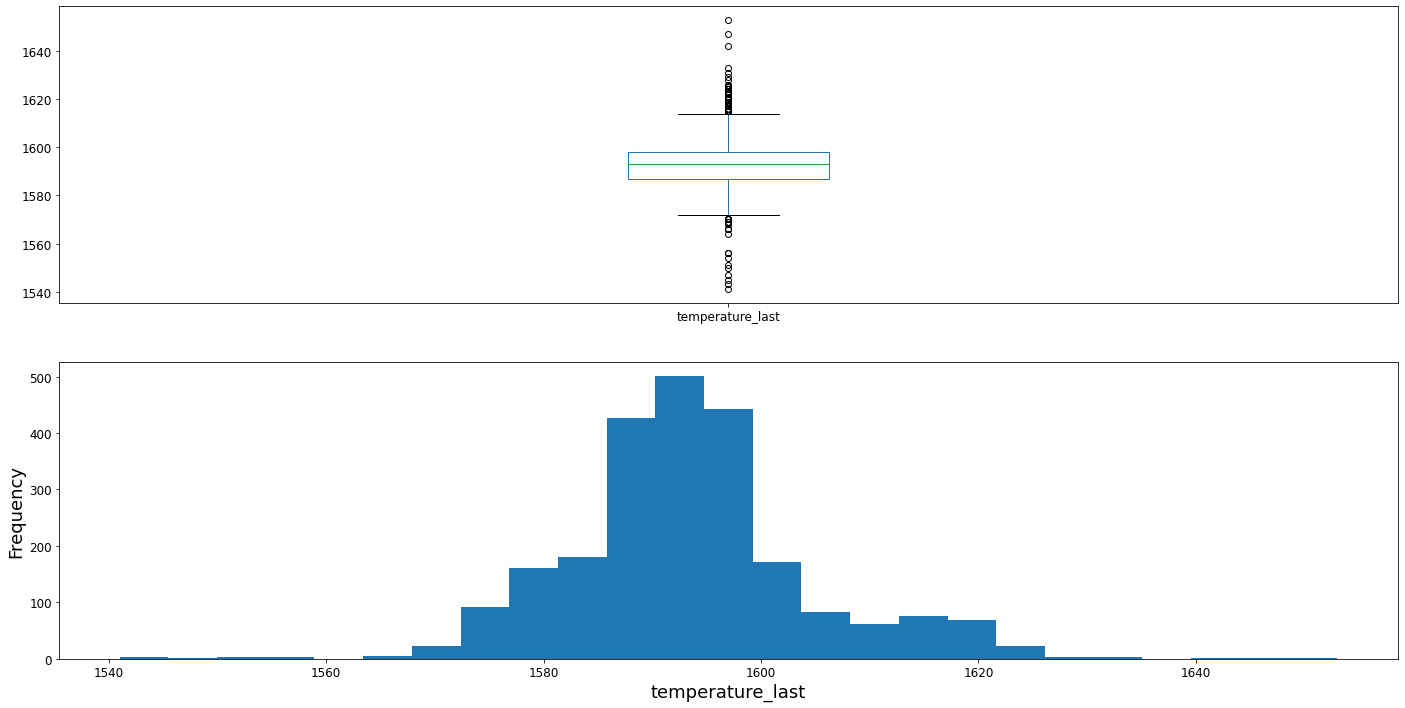

In [34]:
exploratory_data_analysis(data, bad_columns=[])

#### Отобразим таблицу с попарными корреляциями столбцов:

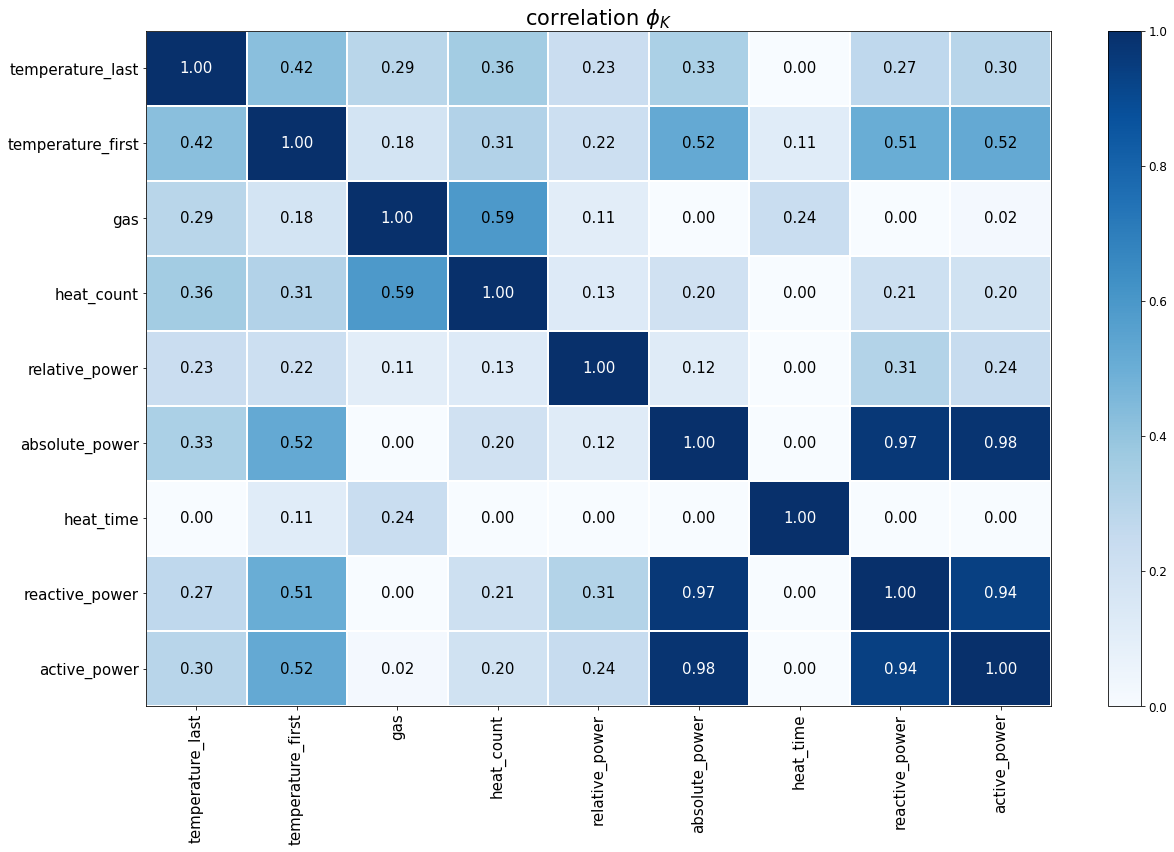

In [35]:
phik_overview = data.phik_matrix(interval_cols=columns)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(18, 12))
plt.tight_layout()

#### Проанализируем как целевой признак `temperature_last` связан со всеми остальными признаками:

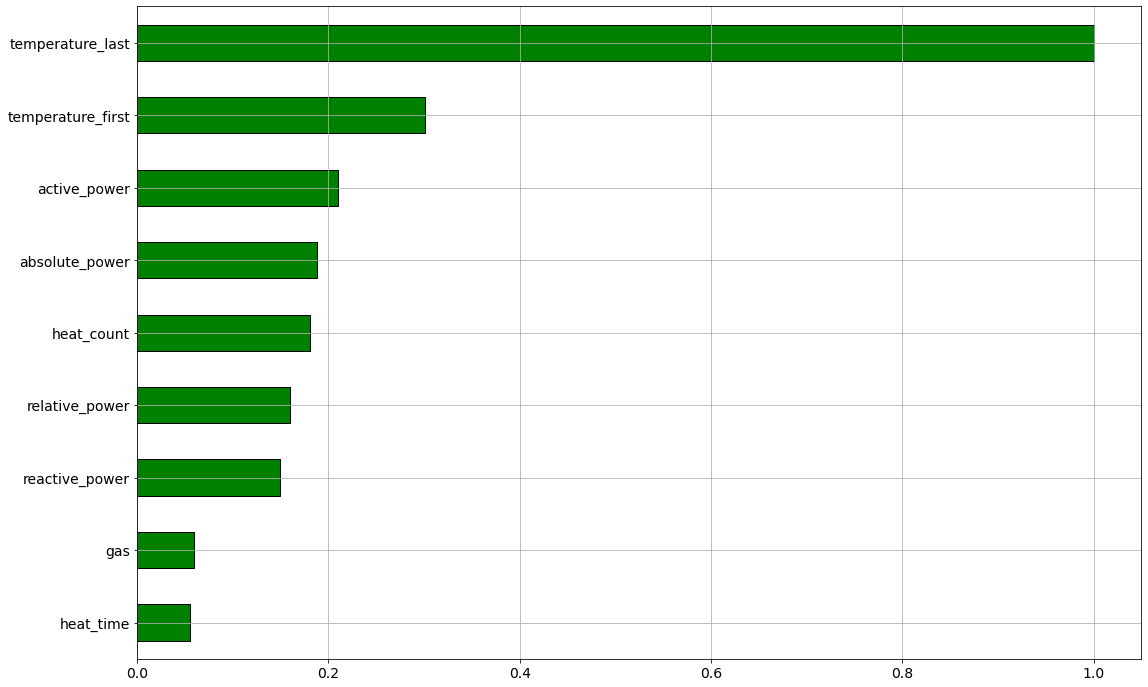

In [36]:
corr_data = data.corr()['temperature_last'][columns].sort_values(key=abs)
abs(corr_data).plot(kind='barh', 
                    fontsize=14,
                    color=(corr_data > 0).map({True: 'g', False: 'r'}),
                    edgecolor='black',
                    title='',
                    grid=True);

### Разделим исходные данные на обучающую и тестовую выборки в соотношении $75\%$/$25\%$:

In [37]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

# check
pd.DataFrame(index=['train', 'test'], columns=['size', 'size_proportion'],
             data=[[train_data.shape[0], round(train_data.shape[0] / data.shape[0] * 100, 2)], 
                   [test_data.shape[0], round(test_data.shape[0] / data.shape[0] * 100, 2)]])

,size,size_proportion
train,1746,75.0000
test,582,25.0000


### Закроем соединение с базой данных:

In [38]:
cur.close() 
conn.close()

### Краткий вывод:
- в данных присутствуют намёки на мультиколлинеарность

<a name="model-learning"></a>
## Обучение моделей

Создадим объекты, которые понадобятся нам в дальнейшем

In [39]:
powers_of_two = [2**i for i in range(1, 7)]
cv_results = pd.DataFrame(columns=['MAE'])
model_params = dict()

### Создадим базовый пайплайн для предобработки данных:

In [40]:
preprocessor = Pipeline(steps=[('standard_scaler', StandardScaler())])

### Напишем функцию для кросс-валидации

In [41]:
def objective_cv(trial, objective, n_splits):
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    
    for train_idx, valid_idx in fold.split(range(len(train_data))):
        train_features = train_data.iloc[train_idx].drop(['temperature_last'], axis=1)
        valid_features = train_data.iloc[valid_idx].drop(['temperature_last'], axis=1)
        train_target = train_data.iloc[train_idx]['temperature_last']
        valid_target = train_data.iloc[valid_idx]['temperature_last']

        dataset = ((train_features, train_target), (valid_features, valid_target))
        scores.append(objective(trial, dataset))
    return np.mean(scores)

### Создадим и обучим наивную модель:

При помощи перебора гиперпараметров найдём наилучшую наивную модель решений

In [42]:
def objective(trial, dataset):
    (train_features, train_target), (valid_features, valid_target) = dataset
    
    regressor = DummyRegressor()
    regressor.strategy = trial.suggest_categorical('strategy', ['mean', 'median'])
        
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    model.fit(train_features, train_target)
    return mean_absolute_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=2)

[I 2024-06-22 13:19:14,445] A new study created in memory with name: no-name-0242bc30-43a3-4a8e-9cf2-d3d5d7c0378f
[I 2024-06-22 13:19:14,492] Trial 0 finished with value: 8.12838491346435 and parameters: {'strategy': 'mean'}. Best is trial 0 with value: 8.12838491346435.
[I 2024-06-22 13:19:14,537] Trial 1 finished with value: 8.101393368808841 and parameters: {'strategy': 'median'}. Best is trial 1 with value: 8.101393368808841.


Добавим результаты кросс-валидации в таблицу

In [43]:
model_params['DummyRegressor'] = study.best_trial.params
cv_results.loc['DummyRegressor', 'MAE'] = study.best_trial.values[0]
cv_results

,MAE
DummyRegressor,8.1014


### Попробуем улучшить результаты прогнозирования при помощи дерева решений:

При помощи перебора гиперпараметров найдём наилучшую модель дерева решений

In [44]:
def objective(trial, dataset):
    (train_features, train_target), (valid_features, valid_target) = dataset
    
    regressor = DecisionTreeRegressor(random_state=RANDOM_STATE)
    regressor.max_depth = trial.suggest_categorical('max_depth', powers_of_two)
    regressor.min_samples_split = trial.suggest_categorical('min_samples_split', powers_of_two)
        
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    model.fit(train_features, train_target)
    return mean_absolute_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=1000)

[I 2024-06-22 13:19:14,556] A new study created in memory with name: no-name-833b9e5b-b6fd-4e0a-bc32-60d42a567705
[I 2024-06-22 13:19:14,707] Trial 0 finished with value: 9.245496795466524 and parameters: {'max_depth': 16, 'min_samples_split': 2}. Best is trial 0 with value: 9.245496795466524.
[I 2024-06-22 13:19:14,799] Trial 1 finished with value: 7.697023292600716 and parameters: {'max_depth': 8, 'min_samples_split': 8}. Best is trial 1 with value: 7.697023292600716.
[I 2024-06-22 13:19:14,911] Trial 2 finished with value: 9.240895626000773 and parameters: {'max_depth': 16, 'min_samples_split': 4}. Best is trial 1 with value: 7.697023292600716.
[I 2024-06-22 13:19:14,997] Trial 3 finished with value: 7.619448486601911 and parameters: {'max_depth': 8, 'min_samples_split': 16}. Best is trial 3 with value: 7.619448486601911.
[I 2024-06-22 13:19:15,110] Trial 4 finished with value: 9.279311775139856 and parameters: {'max_depth': 64, 'min_samples_split': 4}. Best is trial 3 with value: 7

Добавим результаты кросс-валидации в таблицу

In [45]:
model_params['DecisionTreeRegressor'] = study.best_trial.params
cv_results.loc['DecisionTreeRegressor', 'MAE'] = study.best_trial.values[0]
cv_results

,MAE
DummyRegressor,8.1014
DecisionTreeRegressor,7.3355


### Попробуем улучшить результаты прогнозирования при помощи градиентного бустинга:

При помощи перебора гиперпараметров найдём наилучшую модель градиентного бустинга решений

In [46]:
def objective(trial, dataset):  
    (train_features, train_target), (valid_features, valid_target) = dataset

    regressor = LGBMRegressor(random_state=RANDOM_STATE)
    regressor.num_leaves = trial.suggest_categorical('num_leaves', powers_of_two)
    regressor.max_depth = trial.suggest_categorical('max_depth', powers_of_two)
    regressor.n_estimators = trial.suggest_categorical('n_estimators', powers_of_two)
        
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    model.fit(train_features, train_target)
    return mean_absolute_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=50)

[I 2024-06-22 13:20:54,685] A new study created in memory with name: no-name-7bd90b4c-4dc9-4f8e-9d70-01bc9b4136da
[I 2024-06-22 13:20:55,496] Trial 0 finished with value: 7.492415871090577 and parameters: {'num_leaves': 16, 'max_depth': 2, 'n_estimators': 8}. Best is trial 0 with value: 7.492415871090577.
[I 2024-06-22 13:20:55,996] Trial 1 finished with value: 7.564368023658932 and parameters: {'num_leaves': 8, 'max_depth': 16, 'n_estimators': 4}. Best is trial 0 with value: 7.492415871090577.
[I 2024-06-22 13:20:57,787] Trial 2 finished with value: 6.57603027388514 and parameters: {'num_leaves': 8, 'max_depth': 16, 'n_estimators': 64}. Best is trial 2 with value: 6.57603027388514.
[I 2024-06-22 13:20:58,883] Trial 3 finished with value: 7.889024689803155 and parameters: {'num_leaves': 4, 'max_depth': 2, 'n_estimators': 2}. Best is trial 2 with value: 6.57603027388514.
[I 2024-06-22 13:20:59,388] Trial 4 finished with value: 6.907984436762156 and parameters: {'num_leaves': 8, 'max_dep

Добавим результаты кросс-валидации в таблицу

In [47]:
model_params['LGBMRegressor'] = study.best_trial.params
cv_results.loc['LGBMRegressor', 'MAE'] = study.best_trial.values[0]
cv_results

,MAE
DummyRegressor,8.1014
DecisionTreeRegressor,7.3355
LGBMRegressor,6.5722


### Создадим базовой нейронную сеть:

In [48]:
# Класс полносвязной нейронной сети с произвольным числом слоёв и нейронов на каждом слое
class Net(nn.Module):
    def __init__(self, layers_neurons, act_functions):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(layers_neurons[i], layers_neurons[i+1]) for i in range(len(layers_neurons) - 1)])
        self.act_functions = nn.ModuleList(act_functions)
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.act_functions[i](x)
            
        return x
    
# Класс модели нейронной сети для работы с библиотекой sklearn
class NNRegressor(BaseEstimator):
    def __init__(self, net, optimizer, num_epochs=1000, batch_size=512, verbose=False, verbose_epochs=100, **parameters):
        self.net = net
        self.optimizer = optimizer
        self.loss = nn.L1Loss()
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.verbose_epochs = verbose_epochs
        
    def get_params(self, deep=True):
        return {
            'net' : self.net,
            'optimizer': self.optimizer,
            'loss': self.loss,
            'num_epochs': self.num_epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'verbose_epochs': self.verbose_epochs
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        return self
        
    def fit(self, X_train, y_train):                               
        if isinstance(X_train, (pd.DataFrame, pd.Series)):
            X_train = X_train.to_numpy(copy=True)
        if isinstance(y_train, (pd.DataFrame, pd.Series)):
            y_train = y_train.to_numpy(copy=True)

        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train)
        
        num_batches = math.ceil(len(X_train) / self.batch_size)
        self.net.train()
        
        for epoch in range(self.num_epochs):
            order = np.random.permutation(len(X_train))
            
            for batch_idx in range(num_batches):
                start_index = batch_idx * self.batch_size
                self.optimizer.zero_grad()
        
                batch_indexes = order[start_index:start_index+self.batch_size]
                X_batch = X_train[batch_indexes]
                y_batch = y_train[batch_indexes]

                preds = self.net.forward(X_batch).flatten()
                loss_value = self.loss(preds, y_batch)
                loss_value.backward()
                self.optimizer.step()

            if self.verbose and epoch % self.verbose_epochs == 0:
                print(loss_value)

    def predict(self, X_test):
        if isinstance(X_test, (pd.DataFrame, pd.Series)):
            X_test = X_test.to_numpy(copy=True)

        self.net.eval()
        return self.net.forward(torch.FloatTensor(X_test)).detach().numpy().flatten()

### Попробуем улучшить результаты прогнозирования при помощи нейронной сети:

Создадим функцию для генерации архитектур нейронных сетей

In [49]:
n_architecture = 3

def generate_architecture(index):
    if index == 0:
        # Architecture №1
        net = Net([train_data.shape[1] - 1, 1000, 25, 1], [nn.Sigmoid(), nn.ReLU(), nn.Identity()])
        nn.init.kaiming_uniform_(net.layers[0].weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.kaiming_uniform_(net.layers[1].weight, mode='fan_in', nonlinearity='relu')
    elif index == 1:
        # Architecture №2
        net = Net([train_data.shape[1] - 1, 100, 100, 1], [nn.ReLU(), nn.ReLU(), nn.Identity()])
        nn.init.kaiming_uniform_(net.layers[0].weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(net.layers[1].weight, mode='fan_in', nonlinearity='relu')
    else:
        net = Net([train_data.shape[1] - 1, 25, 25, 25, 1], [nn.Tanh(), nn.ReLU(), nn.ReLU(), nn.Identity()])
        nn.init.kaiming_uniform_(net.layers[0].weight, mode='fan_in', nonlinearity='tanh')
        nn.init.kaiming_uniform_(net.layers[1].weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(net.layers[2].weight, mode='fan_in', nonlinearity='relu')

    return net

При помощи перебора гиперпараметров найдём наилучшую модель нейронной сети

In [50]:
def objective(trial, dataset):  
    (train_features, train_target), (valid_features, valid_target) = dataset
    
    net = generate_architecture(trial.suggest_categorical('net_architecture', list(range(n_architecture))))
    batch_size = trial.suggest_categorical('batch_size', powers_of_two)
    
    regressor = NNRegressor(net, 
                            torch.optim.Adam(net.parameters(), lr=1e-3),
                            num_epochs=200,
                            batch_size=128,
                            verbose=False)
        
    model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    model.fit(train_features, train_target)
    return mean_absolute_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=20)

[I 2024-06-22 13:22:20,235] A new study created in memory with name: no-name-375f4961-ff48-4ae8-bff2-7c3bc3630e5c
[I 2024-06-22 13:23:43,291] Trial 0 finished with value: 6.6785471578153786 and parameters: {'net_architecture': 0, 'batch_size': 2}. Best is trial 0 with value: 6.6785471578153786.
[I 2024-06-22 13:25:06,793] Trial 1 finished with value: 6.847849351543312 and parameters: {'net_architecture': 0, 'batch_size': 8}. Best is trial 0 with value: 6.6785471578153786.
[I 2024-06-22 13:26:04,392] Trial 2 finished with value: 11.793849759876753 and parameters: {'net_architecture': 2, 'batch_size': 64}. Best is trial 0 with value: 6.6785471578153786.
[I 2024-06-22 13:27:29,996] Trial 3 finished with value: 6.639606405338594 and parameters: {'net_architecture': 0, 'batch_size': 4}. Best is trial 3 with value: 6.639606405338594.
[I 2024-06-22 13:28:25,186] Trial 4 finished with value: 14.335087468300694 and parameters: {'net_architecture': 2, 'batch_size': 2}. Best is trial 3 with value

Добавим результаты кросс-валидации в таблицу

In [51]:
model_params['NNRegressor'] = study.best_trial.params
cv_results.loc['NNRegressor', 'MAE'] = study.best_trial.values[0]
cv_results

,MAE
DummyRegressor,8.1014
DecisionTreeRegressor,7.3355
LGBMRegressor,6.5722
NNRegressor,6.6396


### Краткий вывод:
- мы обучили модели `DummyRegressor`, `DecisionTreeRegressor`, `LGBMRegressor`, `NNRegressor`
- все модели, кроме наивной, справились с прогнозированием лучше, чем наивная модель
- налучший результат прогнозирования на валидационной выборке показала модель `LGBMRegressor`

<a name="model-testing"></a>
## Тестирование наилучшей модели и демонстрация её работы

In [52]:
test_results = pd.DataFrame(columns=['MAE', 'R2'])

### Обучим наилучшую модель на объединении обучающей и валидационной выборок:

In [53]:
test_features = test_data.drop(['temperature_last'], axis=1)
test_target = test_data['temperature_last']

best_model = LGBMRegressor(**model_params['LGBMRegressor'])
best_model.fit(train_data.drop(['temperature_last'], axis=1), train_data['temperature_last'])
best_predictions = best_model.predict(test_features) 

test_results.loc['LGBMRegressor', 'MAE'] = mean_absolute_error(test_target, best_predictions)
test_results.loc['LGBMRegressor', 'R2'] = r2_score(test_target, best_predictions)
test_results

,MAE,R2
LGBMRegressor,6.3820,0.3579


### Проанализируем важность основных признаков:

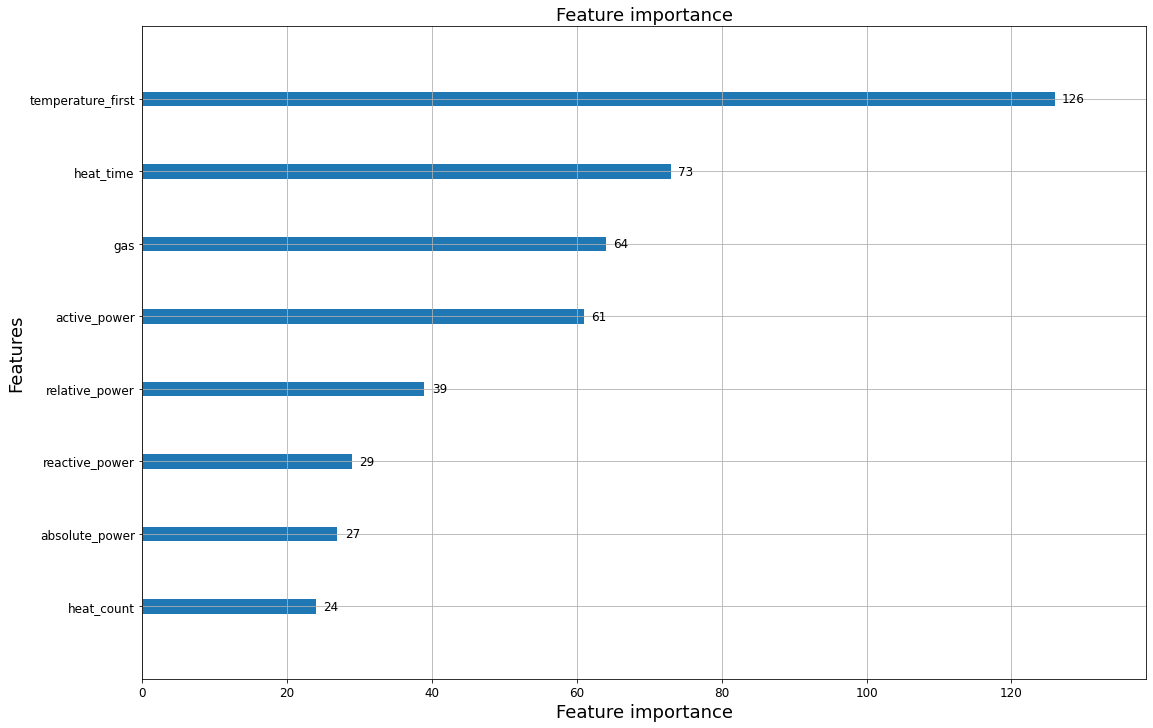

In [54]:
plot_importance(best_model);

### Проанализируем зависимость целевого признака ` temperature_last` от `heat_time`:

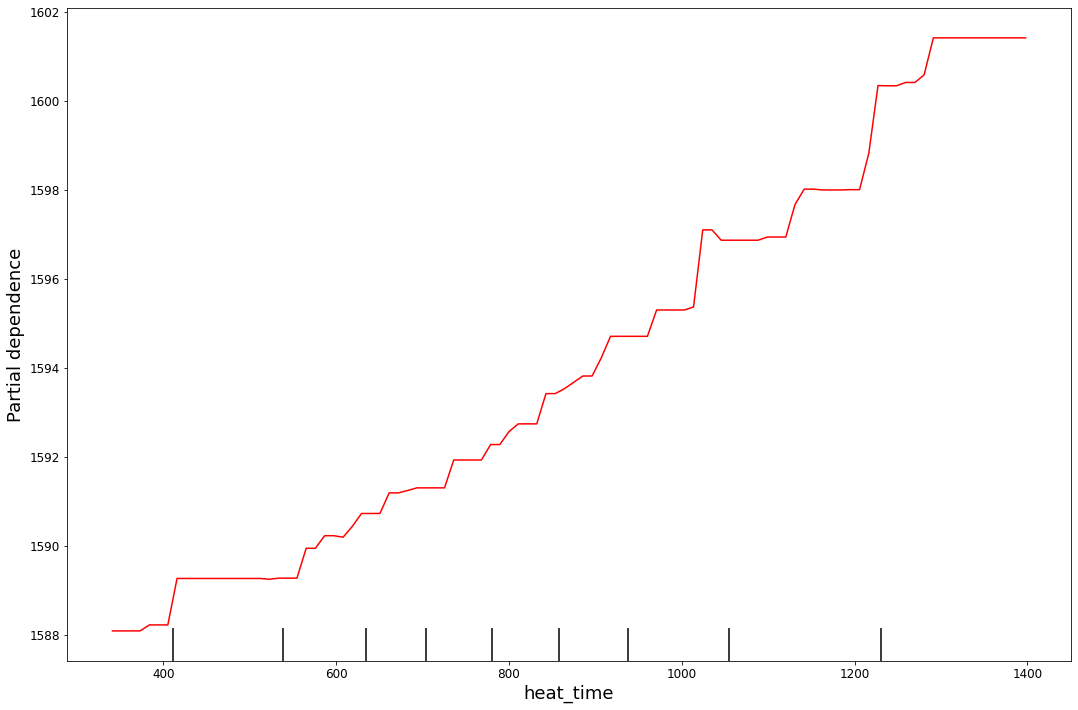

In [55]:
PartialDependenceDisplay.from_estimator(best_model,
                                        test_features,
                                        ['heat_time'],
                                        line_kw={"color": "red"});

### Краткий вывод:
- по мнению наилучшей модели три самых важных признака для прогнозирование — `temperature_first`, `heat_time`, `gas`
- по мнению наилучшей модели с ростом длительности нагревания растёт конечная температура. Это соответствует здравому смыслу

<a name="conclusion"></a>
## Общий вывод
В данных были устранены следующие проблемы:  
- нарушения правил хорошего стиля в названиях столбцов
- несоответствия типов в столбцах
- пропуски в столбцах
- аномальные значения в столбцах  

Было проведено обучение нескольких моделей:  
- мы обучили модели `DummyRegressor`, `DecisionTreeRegressor`, `LGBMRegressor`, `NNRegressor`
- все модели, кроме наивной, справились с прогнозированием лучше, чем наивная модель
- налучший результат прогнозирования на валидационной выборке показала модель `LGBMRegressor`

Мы протестировали наилучшую модель на тестовой выборке:
- по мнению наилучшей модели три самых важных признака для прогнозирование — `temperature_first`, `heat_time`, `active_power`
- по мнению наилучшей модели с ростом длительности нагревания растёт конечная температура. Это соответствует здравому смыслу

Способы улучшить модель:
- рассмотреть более полный набор признаков
- добавить продвинутые методы борьбы с переобучением
- рассмотреть нейронную сеть с более продвинутой архитектурой